In [1]:
import sys

import numpy  as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

from pickle import dump

import matplotlib.pyplot as plt

from utils import plot_nnpredict_45

In [2]:
TAG = '38520208'    # same as the seed you set for generation

inputFile = 'full_%s.csv' %TAG

In [3]:
print("@ %-11s: reading training data from '%s'" %("Info", inputFile))
db_full = pd.read_csv(inputFile, sep=',')
# discard points where vol. inversion failed
db_full = db_full[db_full["imp_vol"]>0.0001]

@ Info       : reading training data from 'full_38520208.csv'


In [4]:
col_to_keep = ["k","theta","sigma","r0","rho","T","Strike", "imp_vol"]

db_full = db_full[col_to_keep].copy()

In [5]:
db_full.head()

,k,theta,sigma,r0,rho,T,Strike,imp_vol
0,3.814102,0.164540,1.432833,0.139525,-0.716335,1.643699,0.595936,0.434758
1,4.696243,0.091518,1.783571,0.112681,-0.743819,0.447255,1.272533,0.194233
2,3.673141,0.170460,2.493242,0.120849,-0.554280,1.552593,1.130810,0.309205
3,4.133072,0.193795,1.853701,0.073172,-0.545845,1.926426,0.947033,0.385543
4,2.782822,0.143705,1.232721,0.102763,-0.817616,0.871505,0.567104,0.460013


In [6]:
i_vols = db_full["imp_vol"].values
params = db_full.drop(columns="imp_vol").values

N_params_mdl = params.shape[1] - 1 - 1

#### Tipically the scaler is fitted just on train data, but for this problem is not a big issue to fit on the whole dataset!

In [7]:
scaler = StandardScaler().fit(params)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(params, i_vols, test_size=0.10, random_state=42)

In [9]:
#scaler = StandardScaler().fit(x_train)

In [10]:
x_train_transform = scaler.transform(x_train)
x_test_transform = scaler.transform(x_test)

### Building Neural Network

In [11]:
N_hiddenLayers = 4
N_nodes = 64
i = keras.layers.Input(shape=(N_params_mdl+1+1, ))
x = keras.layers.Dense(N_nodes, activation='swish')(i)
c = 0
while c < N_hiddenLayers:
    x = keras.layers.Dense(N_nodes, activation='swish')(x)
    c += 1
x = keras.layers.Dense(1, activation='linear')(x)

model = keras.models.Model(inputs=i, outputs=x)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65    

In [13]:
def RMSE(y, y_hat):
    return K.sqrt(K.mean(K.square(y_hat - y)))

model.compile(loss = RMSE, optimizer = "adam")

In [14]:
LEN = len(x_train_transform)
patience =  100
N_epochs = 1500

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=patience ,
                               restore_best_weights=True)

In [15]:
model.fit(x_train_transform, y_train, epochs=N_epochs, verbose=True, batch_size=LEN, validation_split=.10, 
          callbacks=[early_stopping])

Epoch 1/1500
1/1 [==============================] - 1s 1s/step - loss: 0.3153 - val_loss: 0.2972
Epoch 2/1500
1/1 [==============================] - 0s 207ms/step - loss: 0.2987 - val_loss: 0.2809
Epoch 3/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.2822 - val_loss: 0.2642
Epoch 4/1500
1/1 [==============================] - 0s 201ms/step - loss: 0.2654 - val_loss: 0.2467
Epoch 5/1500
1/1 [==============================] - 0s 184ms/step - loss: 0.2478 - val_loss: 0.2280
Epoch 6/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.2289 - val_loss: 0.2077
Epoch 7/1500
1/1 [==============================] - 0s 197ms/step - loss: 0.2085 - val_loss: 0.1856
Epoch 8/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.1862 - val_loss: 0.1615
Epoch 9/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.1620 - val_loss: 0.1356
Epoch 10/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.1358 - val_loss: 0.1087
Ep

1/1 [==============================] - 0s 230ms/step - loss: 0.0223 - val_loss: 0.0223
Epoch 83/1500
1/1 [==============================] - 0s 215ms/step - loss: 0.0221 - val_loss: 0.0222
Epoch 84/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0219 - val_loss: 0.0220
Epoch 85/1500
1/1 [==============================] - 0s 200ms/step - loss: 0.0218 - val_loss: 0.0219
Epoch 86/1500
1/1 [==============================] - 0s 199ms/step - loss: 0.0217 - val_loss: 0.0217
Epoch 87/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0215 - val_loss: 0.0216
Epoch 88/1500
1/1 [==============================] - 0s 201ms/step - loss: 0.0214 - val_loss: 0.0215
Epoch 89/1500
1/1 [==============================] - 0s 195ms/step - loss: 0.0213 - val_loss: 0.0214
Epoch 90/1500
1/1 [==============================] - 0s 186ms/step - loss: 0.0212 - val_loss: 0.0213
Epoch 91/1500
1/1 [==============================] - 0s 213ms/step - loss: 0.0211 - val_loss: 0.0212
Epoc

1/1 [==============================] - 0s 200ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 163/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 164/1500
1/1 [==============================] - 0s 199ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 165/1500
1/1 [==============================] - 0s 215ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 166/1500
1/1 [==============================] - 0s 202ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 167/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 168/1500
1/1 [==============================] - 0s 213ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 169/1500
1/1 [==============================] - 0s 236ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 170/1500
1/1 [==============================] - 0s 234ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 171/1500
1/1 [==============================] - 0s 219ms/step - loss: 0.0121 - val_loss: 0.

1/1 [==============================] - 0s 204ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 243/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 244/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 245/1500
1/1 [==============================] - 0s 191ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 246/1500
1/1 [==============================] - 0s 207ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 247/1500
1/1 [==============================] - 0s 191ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 248/1500
1/1 [==============================] - 0s 211ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 249/1500
1/1 [==============================] - 0s 201ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 250/1500
1/1 [==============================] - 0s 199ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 251/1500
1/1 [==============================] - 0s 196ms/step - loss: 0.0095 - val_loss: 0.

1/1 [==============================] - 0s 205ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 323/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 324/1500
1/1 [==============================] - 0s 199ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 325/1500
1/1 [==============================] - 0s 198ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 326/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 327/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 328/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 329/1500
1/1 [==============================] - 0s 200ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 330/1500
1/1 [==============================] - 0s 191ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 331/1500
1/1 [==============================] - 0s 200ms/step - loss: 0.0084 - val_loss: 0.

1/1 [==============================] - 0s 213ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 403/1500
1/1 [==============================] - 0s 208ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 404/1500
1/1 [==============================] - 0s 212ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 405/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 406/1500
1/1 [==============================] - 0s 201ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 407/1500
1/1 [==============================] - 0s 202ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 408/1500
1/1 [==============================] - 0s 198ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 409/1500
1/1 [==============================] - 0s 218ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 410/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 411/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.0076 - val_loss: 0.

1/1 [==============================] - 0s 216ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 483/1500
1/1 [==============================] - 0s 196ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 484/1500
1/1 [==============================] - 0s 200ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 485/1500
1/1 [==============================] - 0s 200ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 486/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 487/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 488/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 489/1500
1/1 [==============================] - 0s 208ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 490/1500
1/1 [==============================] - 0s 211ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 491/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0070 - val_loss: 0.

1/1 [==============================] - 0s 207ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 563/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 564/1500
1/1 [==============================] - 0s 216ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 565/1500
1/1 [==============================] - 0s 221ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 566/1500
1/1 [==============================] - 0s 193ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 567/1500
1/1 [==============================] - 0s 220ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 568/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 569/1500
1/1 [==============================] - 0s 222ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 570/1500
1/1 [==============================] - 0s 211ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 571/1500
1/1 [==============================] - 0s 233ms/step - loss: 0.0067 - val_loss: 0.

1/1 [==============================] - 0s 209ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 643/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 644/1500
1/1 [==============================] - 0s 192ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 645/1500
1/1 [==============================] - 0s 209ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 646/1500
1/1 [==============================] - 0s 207ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 647/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 648/1500
1/1 [==============================] - 0s 212ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 649/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 650/1500
1/1 [==============================] - 0s 208ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 651/1500
1/1 [==============================] - 0s 208ms/step - loss: 0.0059 - val_loss: 0.

1/1 [==============================] - 0s 196ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 723/1500
1/1 [==============================] - 0s 232ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 724/1500
1/1 [==============================] - 0s 193ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 725/1500
1/1 [==============================] - 0s 219ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 726/1500
1/1 [==============================] - 0s 202ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 727/1500
1/1 [==============================] - 0s 201ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 728/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 729/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 730/1500
1/1 [==============================] - 0s 220ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 731/1500
1/1 [==============================] - 0s 223ms/step - loss: 0.0052 - val_loss: 0.

1/1 [==============================] - 0s 204ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 803/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 804/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 805/1500
1/1 [==============================] - 0s 188ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 806/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 807/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 808/1500
1/1 [==============================] - 0s 188ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 809/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 810/1500
1/1 [==============================] - 0s 208ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 811/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0050 - val_loss: 0.

1/1 [==============================] - 0s 206ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 883/1500
1/1 [==============================] - 0s 185ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 884/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 885/1500
1/1 [==============================] - 0s 200ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 886/1500
1/1 [==============================] - 0s 188ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 887/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 888/1500
1/1 [==============================] - 0s 213ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 889/1500
1/1 [==============================] - 0s 226ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 890/1500
1/1 [==============================] - 0s 222ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 891/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0046 - val_loss: 0.

1/1 [==============================] - 0s 228ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 963/1500
1/1 [==============================] - 0s 232ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 964/1500
1/1 [==============================] - 0s 202ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 965/1500
1/1 [==============================] - 0s 226ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 966/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 967/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 968/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 969/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 970/1500
1/1 [==============================] - 0s 213ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 971/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0045 - val_loss: 0.

1/1 [==============================] - 0s 242ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 1043/1500
1/1 [==============================] - 0s 225ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 1044/1500
1/1 [==============================] - 0s 226ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 1045/1500
1/1 [==============================] - 0s 224ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 1046/1500
1/1 [==============================] - 0s 231ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 1047/1500
1/1 [==============================] - 0s 248ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 1048/1500
1/1 [==============================] - 0s 234ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 1049/1500
1/1 [==============================] - 0s 231ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 1050/1500
1/1 [==============================] - 0s 218ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 1051/1500
1/1 [==============================] - 0s 231ms/step - loss: 0.0043 - val

1/1 [==============================] - 0s 214ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 1122/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 1123/1500
1/1 [==============================] - 0s 232ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 1124/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 1125/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 1126/1500
1/1 [==============================] - 0s 226ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 1127/1500
1/1 [==============================] - 0s 213ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 1128/1500
1/1 [==============================] - 0s 230ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 1129/1500
1/1 [==============================] - 0s 215ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 1130/1500
1/1 [==============================] - 0s 195ms/step - loss: 0.0041 - val

1/1 [==============================] - 0s 198ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 1201/1500
1/1 [==============================] - 0s 218ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 1202/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 1203/1500
1/1 [==============================] - 0s 219ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 1204/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 1205/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 1206/1500
1/1 [==============================] - 0s 203ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 1207/1500
1/1 [==============================] - 0s 214ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 1208/1500
1/1 [==============================] - 0s 201ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 1209/1500
1/1 [==============================] - 0s 204ms/step - loss: 0.0039 - val

1/1 [==============================] - 0s 214ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1280/1500
1/1 [==============================] - 0s 213ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1281/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1282/1500
1/1 [==============================] - 0s 212ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1283/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1284/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1285/1500
1/1 [==============================] - 0s 226ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1286/1500
1/1 [==============================] - 0s 219ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 1287/1500
1/1 [==============================] - 0s 218ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 1288/1500
1/1 [==============================] - 0s 206ms/step - loss: 0.0038 - val

1/1 [==============================] - 0s 212ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1359/1500
1/1 [==============================] - 0s 215ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1360/1500
1/1 [==============================] - 0s 210ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1361/1500
1/1 [==============================] - 0s 197ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1362/1500
1/1 [==============================] - 0s 205ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 1363/1500
1/1 [==============================] - 0s 208ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1364/1500
1/1 [==============================] - 0s 209ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1365/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1366/1500
1/1 [==============================] - 0s 207ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1367/1500
1/1 [==============================] - 0s 207ms/step - loss: 0.0037 - val

1/1 [==============================] - 0s 220ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 1438/1500
1/1 [==============================] - 0s 230ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 1439/1500
1/1 [==============================] - 0s 216ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 1440/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 1441/1500
1/1 [==============================] - 0s 234ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 1442/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 1443/1500
1/1 [==============================] - 0s 223ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 1444/1500
1/1 [==============================] - 0s 224ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 1445/1500
1/1 [==============================] - 0s 229ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 1446/1500
1/1 [==============================] - 0s 217ms/step - loss: 0.0036 - val

In [16]:
model.save_weights('Heston_NNWeights_pntwise_.h5')

In [17]:
scalerFile = "scaler_%s.pkl" %TAG
dump(scaler, open(scalerFile,'wb'))
print("@ %-11s: scaler saved to '%s'" %("Info", scalerFile))

@ Info       : scaler saved to 'scaler_38520208.pkl'


In [18]:
model.save('my_model.h5')

#### Load Weights

In [19]:
model.load_weights('Heston_NNWeights_pntwise_.h5')

NNWeights = []
for i in range(1, len(model.layers)):
    NNWeights.append(model.layers[i].get_weights())

410/410 [==============================] - 0s 586us/step


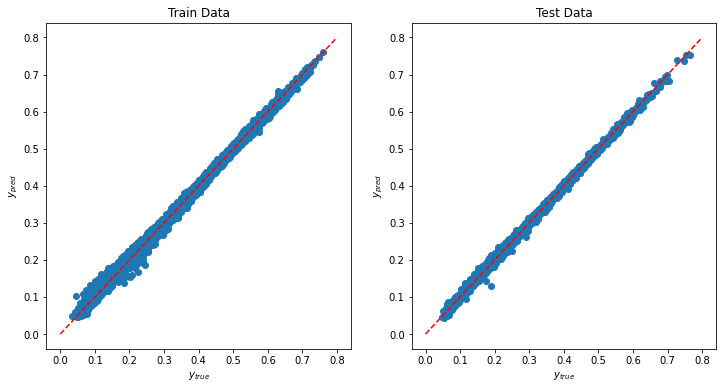

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ivol_train_pred = model.predict(x_train_transform).ravel()

ivol_test_pred = model.predict(x_test_transform).ravel()

ax[0].scatter(y_train, ivol_train_pred)
ax[0].plot([0,0.8],[0,0.8], "--", c="red")
ax[0].set_xlabel("$y_{true}$")
ax[0].set_ylabel("$y_{pred}$")
ax[0].set_title("Train Data")


ax[1].scatter(y_test, ivol_test_pred)
ax[1].plot([0,0.8],[0,0.8], "--", c="red")
ax[1].set_xlabel("$y_{true}$")
ax[1].set_ylabel("$y_{pred}$")
ax[1].set_title("Test Data")

plt.show()


# Comparison with a single point using smiles

#### Coding the NN in numpy and separate the true model parameters from $[T, K]$

In [21]:
N_layers = N_hiddenLayers + 1

def swish(x):
    return x/(np.exp(-x)+1)

def NNFun(params, T, K):
    N = len(T)
    PARAMS = np.array(N*[params])
    input1 = np.c_[PARAMS, T, K] 
    for i in range(N_layers):
        input1 = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
        input1 = swish(input1)
    i += 1
    X = np.dot(input1, NNWeights[i][0]) + NNWeights[i][1]
    X = [el[0] for el in X]
    X = np.array(X)
    return X

In [22]:
dout = np.loadtxt('Heston_gridSurf.txt', dtype=float)

### This file is organized as follow:
- the file is a list of values
- the first 5 values are the model parameter
- the other values are the implied volatilityies for a specific configuration of $[T,K]$ 
- $T = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]$
- $K = [0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2, 1.3, 1.4, 1.5]$

So the file is:

param_1, ..., param_5, ivol_T1_K1, ivol_T1_K2, .... ivol_TN,KN

param_1, ..., param_5, ivol_0.1_0.5, ivol_0.1_0.6, .... ivol_2.0_1.5



In [23]:
dout

array([ 2.12517174,  0.05325828,  1.45788856,  0.09414785, -0.73709957,
        0.6146808 ,  0.55145796,  0.48961633,  0.42607904,  0.35634075,
        0.27146541,  0.20790548,  0.21398171,  0.22956008,  0.2448832 ,
        0.2588586 ,  0.55958997,  0.49708481,  0.4354921 ,  0.37186752,
        0.30310462,  0.22805656,  0.17826551,  0.18432546,  0.20036896,
        0.21560763,  0.22918573,  0.48941445,  0.43019097,  0.37307324,
        0.31644966,  0.25923404,  0.20231129,  0.16187725,  0.15944454,
        0.17104324,  0.18383872,  0.19589674,  0.43802647,  0.38439846,
        0.33393322,  0.28529295,  0.23779377,  0.19180018,  0.15673677,
        0.14829015,  0.15465313,  0.16426193,  0.17406075,  0.40162961,
        0.35351476,  0.30892187,  0.26656666,  0.22568044,  0.18686883,
        0.15619132,  0.1438904 ,  0.1458173 ,  0.15249708,  0.1600698 ,
        0.37533115,  0.33190484,  0.29187742,  0.25425123,  0.21836342,
        0.18444537,  0.15649075,  0.14267611,  0.14093542,  0.14

In [24]:
### [0.0,0.0] is just a placeholder because the scaler expect a vector of dims nparams+2 (maturity & strike)
params = scaler.transform([dout[:N_params_mdl].tolist()+[0.0,0.0]])[0][:N_params_mdl]
vol_surf = dout[N_params_mdl:]

In [43]:
maturities = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.]
N_maturities = len(maturities)
strikes = [0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2, 1.3, 1.4, 1.5]
N_strikes = len(strikes)
T = []

### Scale maturities and strikes with placeholder (zero vectors in other fields)
### Then buil two lists from the cartesian prodoct of maturities X strikes

for maturity in maturities:
    T.append(scaler.transform([N_params_mdl*[0] + [maturity] + [0]])[0][N_params_mdl])
T = [t for t in T for _ in range(N_strikes)]

K = []
for strike in strikes:
    K.append(scaler.transform([N_params_mdl*[0] + [0] + [strike]])[0][N_params_mdl+1])
K = [el for sublist in N_maturities*[K] for el in sublist]

In [44]:
params

array([-1.62340243, -0.94443751, -0.67482052, -0.19883731, -0.32291125])

In [45]:
T, K

([-1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.733840832008478,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -1.3690299543830258,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.821813637944848,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  -0.2745973215066699,
  0.272618

In [46]:
#import itertools
#maturities = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.]
#strikes = [0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2, 1.3, 1.4, 1.5]
#T_ = []
#K_ = []
#for element in itertools.product(maturities,strikes):
#    T_.append(element[0])
#    K_.append(element[1])
#    
#

In [47]:
#T_

In [48]:
ivol_NN = NNFun(params, T, K)

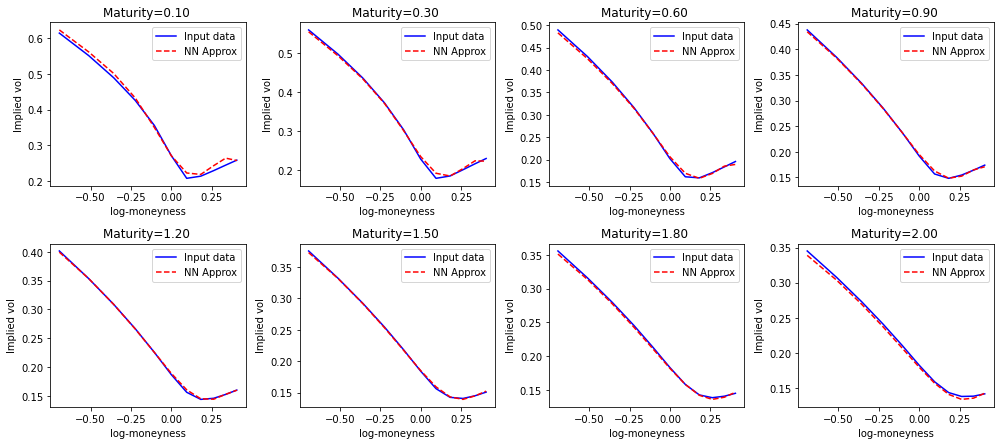

In [49]:
spot = 1.
N_strikes = 11

plt.figure(1, figsize=(14,12))
for i in range(8):
    plt.subplot(4, 4, i+1)
    
    plt.plot(np.log(np.array(strikes)/spot), vol_surf[i*N_strikes:(i+1)*N_strikes], 'b', label="Input data")
    plt.plot(np.log(np.array(strikes)/spot), ivol_NN[i*N_strikes:(i+1)*N_strikes], '--r', label="NN Approx")
    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

### alternative approach

In [50]:
dout = np.loadtxt('Heston_gridSurf.txt', dtype=float)

In [51]:
vol_surf = dout[N_params_mdl:]
params = dout[:N_params_mdl]

In [52]:
maturities = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.]
strikes = [0.5, 0.6, 0.7, 0.8, 0.9, 1., 1.1, 1.2, 1.3, 1.4, 1.5]


In [53]:
import itertools

mat_data = []
for mat, stri in itertools.product(maturities, strikes):
    mat_data.append(np.concatenate((params,[mat, stri])))

In [54]:
col_name = ['k', 'theta', 'sigma', 'r0', 'rho', 'T', 'Strike']
dataset = pd.DataFrame(mat_data, columns=col_name)

dataset["i_vol"] = vol_surf

In [55]:
x_data = dataset[col_name].values

dataset["i_vol_pred"] = model.predict(scaler.transform(x_data)).ravel()

3/3 [==============================] - 0s 1ms/step


In [56]:
dataset

,k,theta,sigma,r0,rho,T,Strike,i_vol,i_vol_pred
0,2.125172,0.053258,1.457889,0.094148,-0.7371,0.1,0.5,0.614681,0.623595
1,2.125172,0.053258,1.457889,0.094148,-0.7371,0.1,0.6,0.551458,0.561706
2,2.125172,0.053258,1.457889,0.094148,-0.7371,0.1,0.7,0.489616,0.501618
3,2.125172,0.053258,1.457889,0.094148,-0.7371,0.1,0.8,0.426079,0.432910
4,2.125172,0.053258,1.457889,0.094148,-0.7371,0.1,0.9,0.356341,0.350712
...,...,...,...,...,...,...,...,...,...
83,2.125172,0.053258,1.457889,0.094148,-0.7371,2.0,1.1,0.159464,0.157442
84,2.125172,0.053258,1.457889,0.094148,-0.7371,2.0,1.2,0.144117,0.141534
85,2.125172,0.053258,1.457889,0.094148,-0.7371,2.0,1.3,0.138628,0.134481
86,2.125172,0.053258,1.457889,0.094148,-0.7371,2.0,1.4,0.139045,0.136252


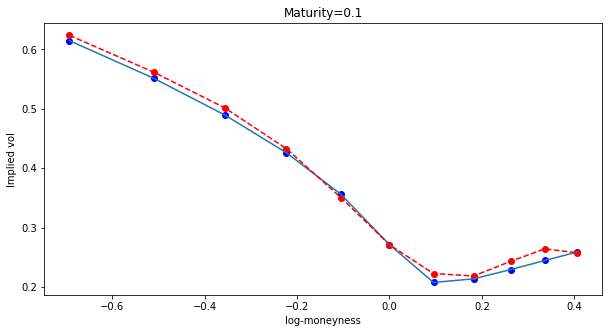

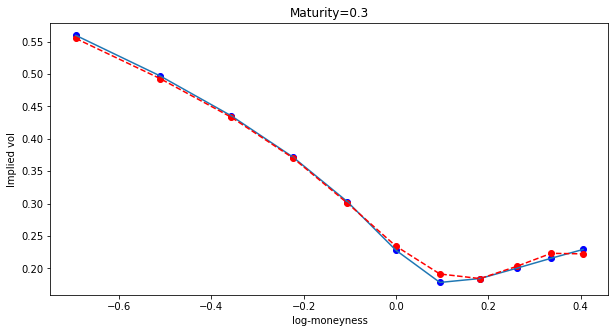

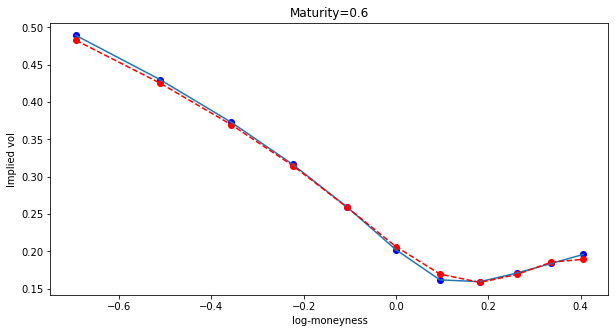

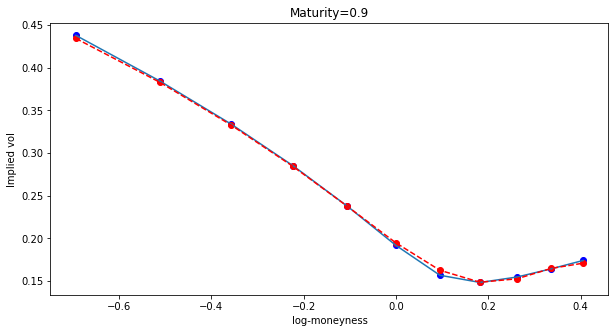

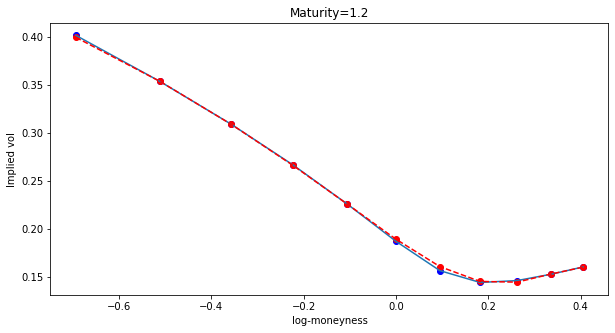

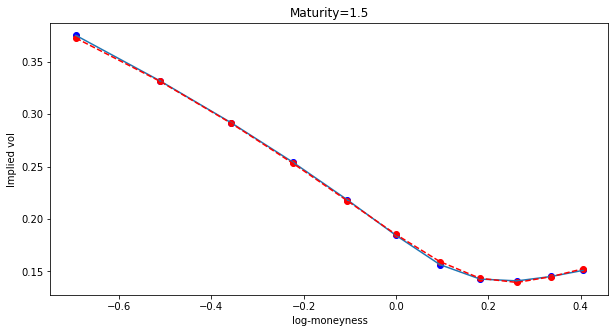

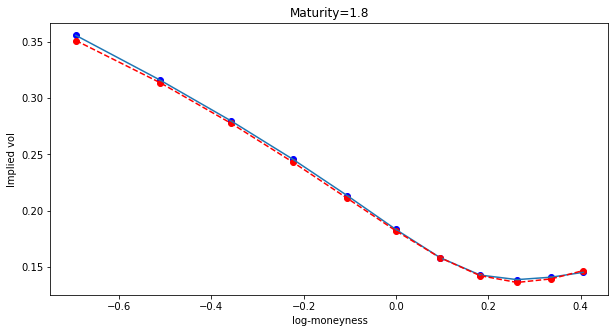

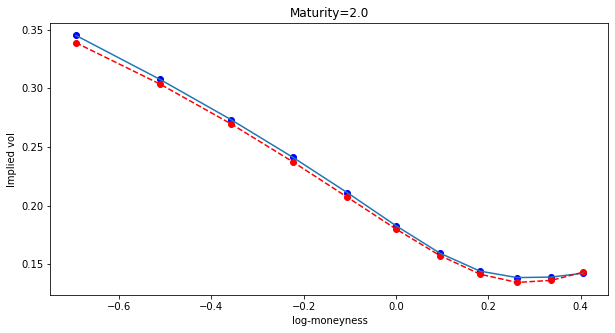

""


In [57]:
def plot_smile(df):
    mat = df['T'].values[0]
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    ax.plot(np.log(df["Strike"]), df["i_vol"], label = "Input Data")
    ax.scatter(np.log(df["Strike"]), df["i_vol"], c="blue")
    ax.plot(np.log(df["Strike"]), df["i_vol_pred"],'--r', label = "NN approx")
    ax.scatter(np.log(df["Strike"]), df["i_vol_pred"], c="red")
    ax.set_title(f"Maturity={mat}")
    ax.set_xlabel("log-moneyness")
    ax.set_ylabel("Implied vol")
    plt.show()
    

dataset.groupby("T").apply(plot_smile)